# Requirements

In [1]:
import re
import pandas as pd
import shapely.ops

pd.set_option('display.max_columns', 200)
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from pyproj import Geod
from shapely.geometry import LineString
import seaborn as sns
import sddk
from pyproj import Proj, transform
import pyproj
from shapely.ops import unary_union
from shapely.ops import transform

In [7]:
# global parameters for plots
plt.style.use("default")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")

# Import datasets

In [3]:
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson", driver="GeoJSON")

In [4]:
pleiades_regions = pleiades_regions.to_crs(3035)
pleiades_regions_merged = pleiades_regions.unary_union
pleiades_regions_merged_buffer = pleiades_regions_merged.buffer(distance=5000)

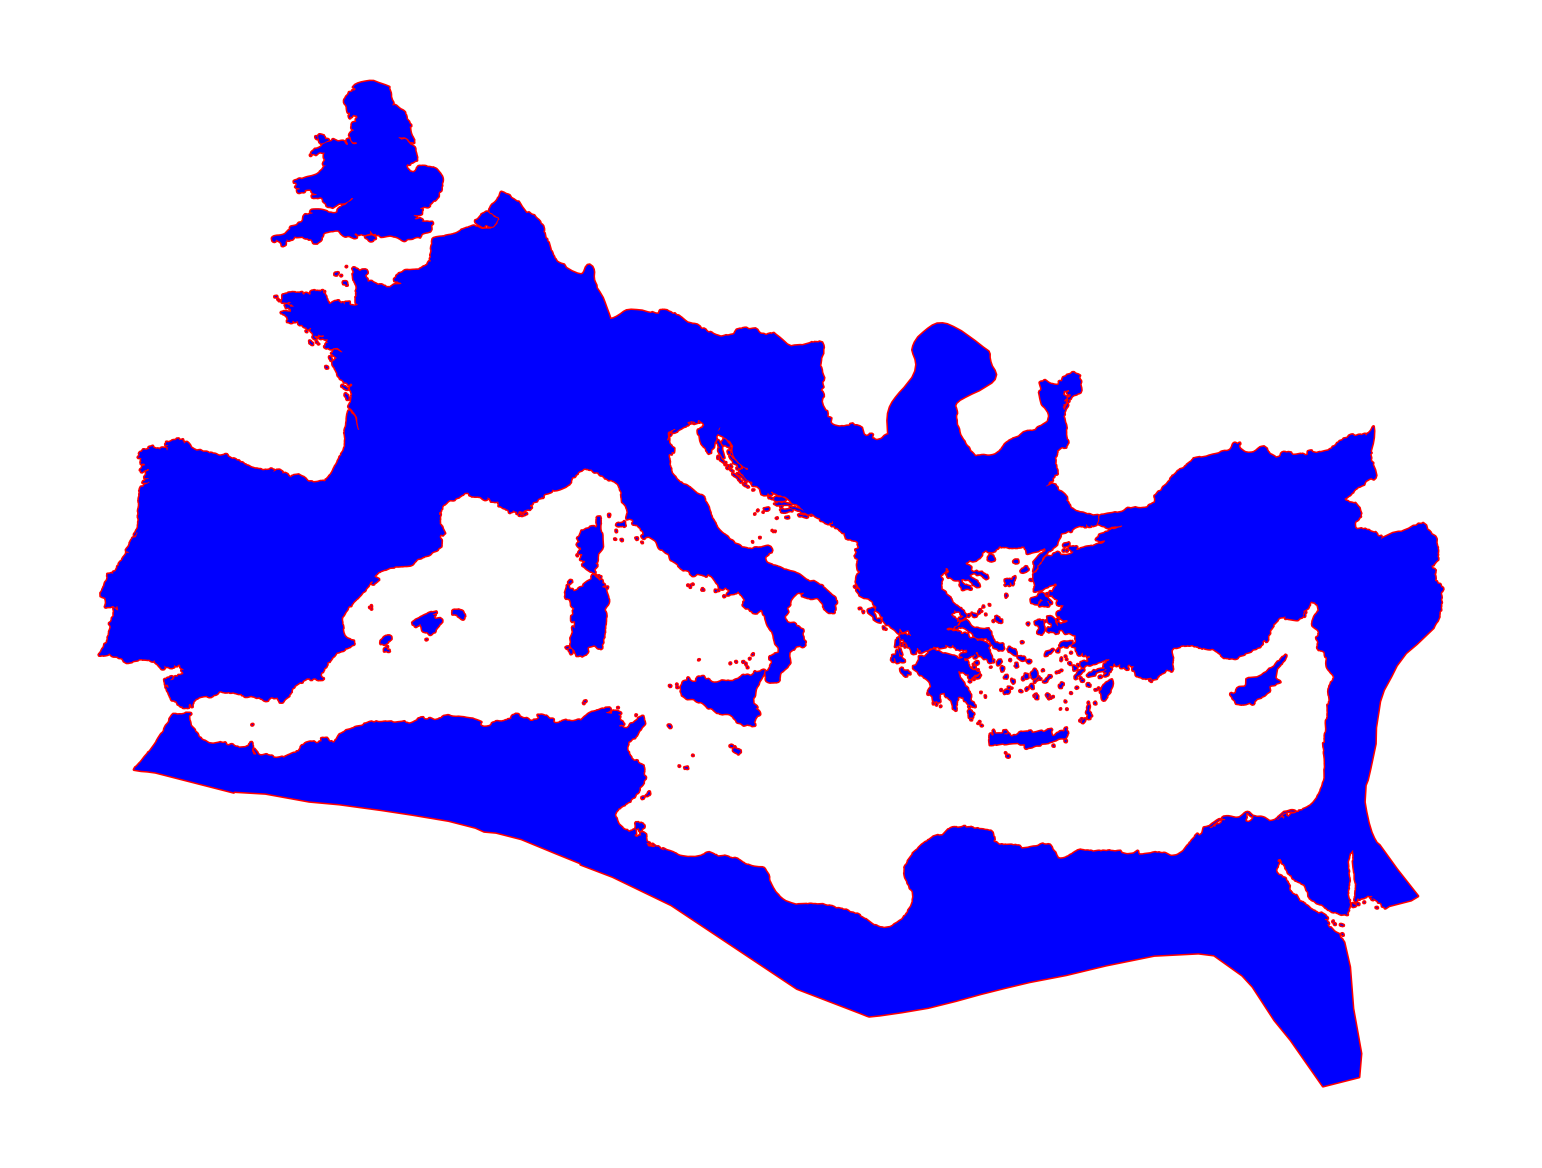

In [8]:
fig, ax = plt.subplots()
gpd.GeoSeries(pleiades_regions_merged_buffer).plot(ax=ax, color="red")
gpd.GeoSeries(pleiades_regions_merged).plot(ax=ax, color="blue")
ax.set_axis_off()

In [9]:
medsea = gpd.read_file("https://geo.vliz.be/geoserver/wfs?request=getfeature&service=wfs&version=1.1.0&typename=MarineRegions:iho&outputformat=json&filter=%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3314%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3315%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3322%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3324%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3346%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3351%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3363%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3386%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E4279%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E4280%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E", driver="GeoJSON")

In [10]:
medsea.to_file("../data/medsea.geojson", driver="GeoJSON")

In [11]:
medsea = medsea.to_crs(3035)
medsea_merged = medsea.unary_union
medsea_merged_buffer = medsea_merged.buffer(distance=5000)

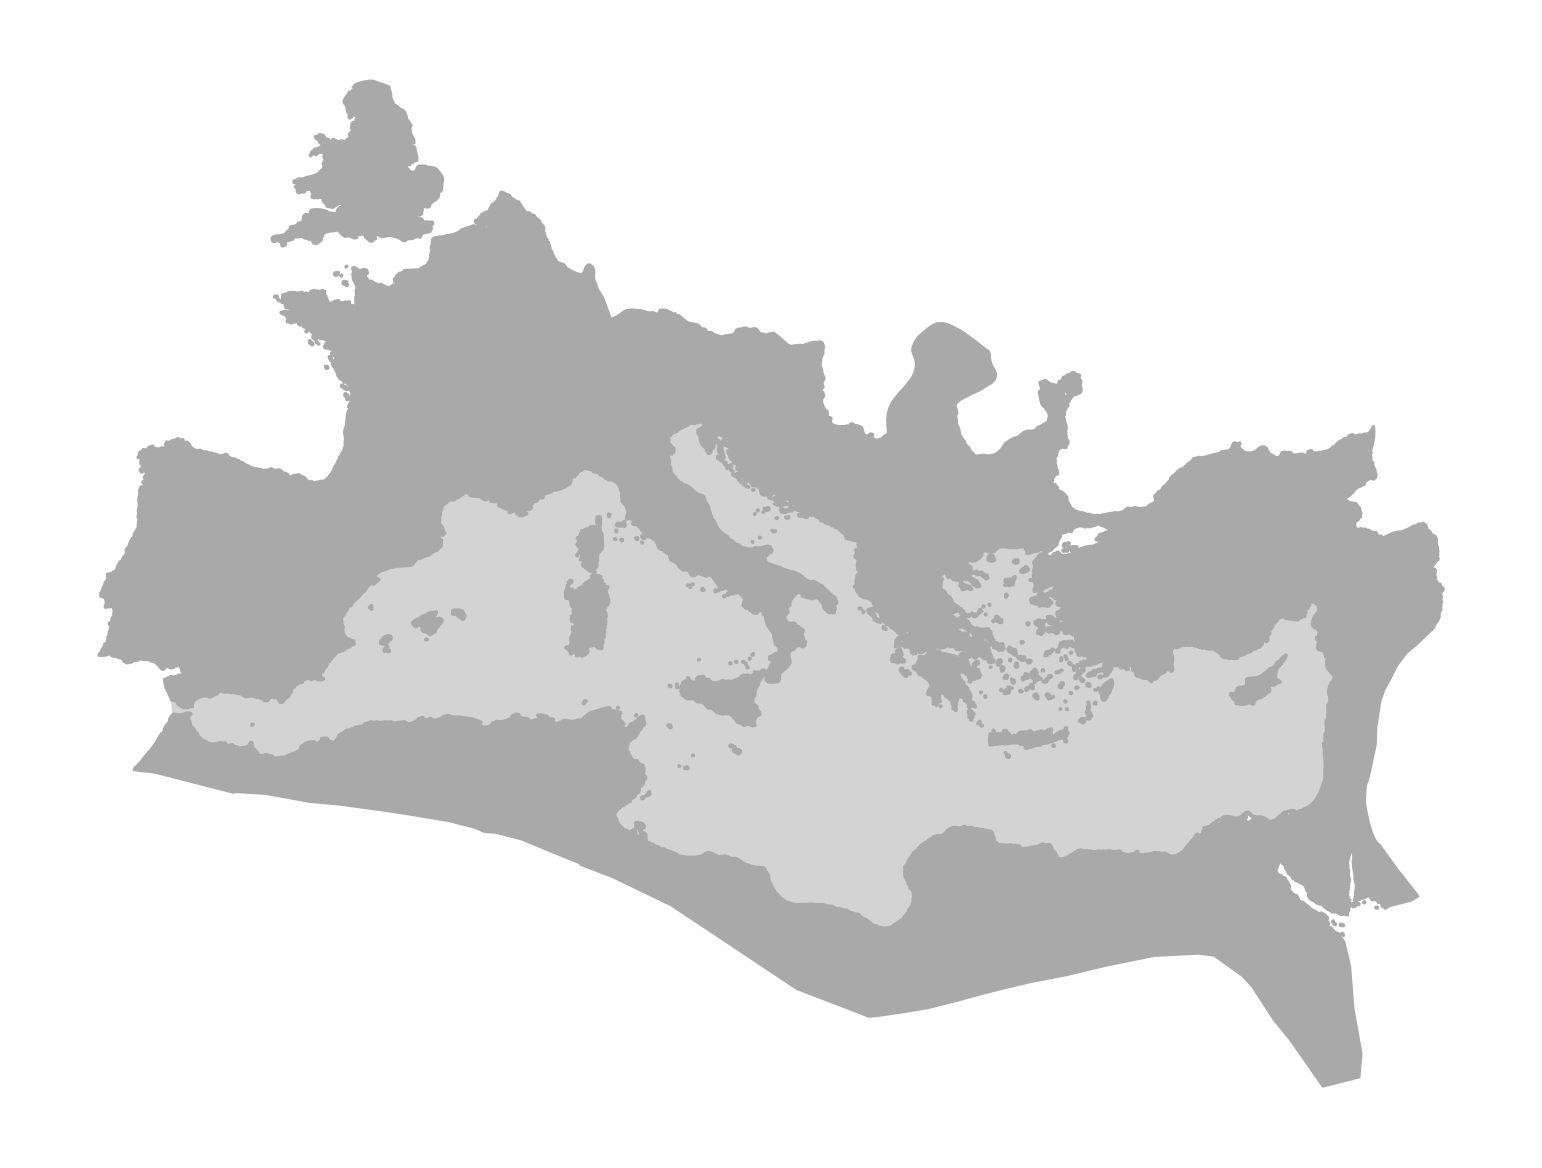

In [41]:
fig, ax = plt.subplots()
gpd.GeoSeries(medsea_merged_buffer).plot(ax=ax, color="lightgrey")
gpd.GeoSeries(pleiades_regions_merged_buffer).plot(ax=ax, color="darkgrey")
ax.set_axis_off()

In [16]:
GIST = gpd.read_parquet("../data/large_data/GIST_v0-1.parquet")

In [17]:
GIST = GIST.to_crs(3035)

In [19]:
for col in GIST.columns:
    if isinstance(GIST[col].tolist()[0], dict):
        GIST[col] = GIST[col].apply(lambda x: {"data" : list(x["data"])})

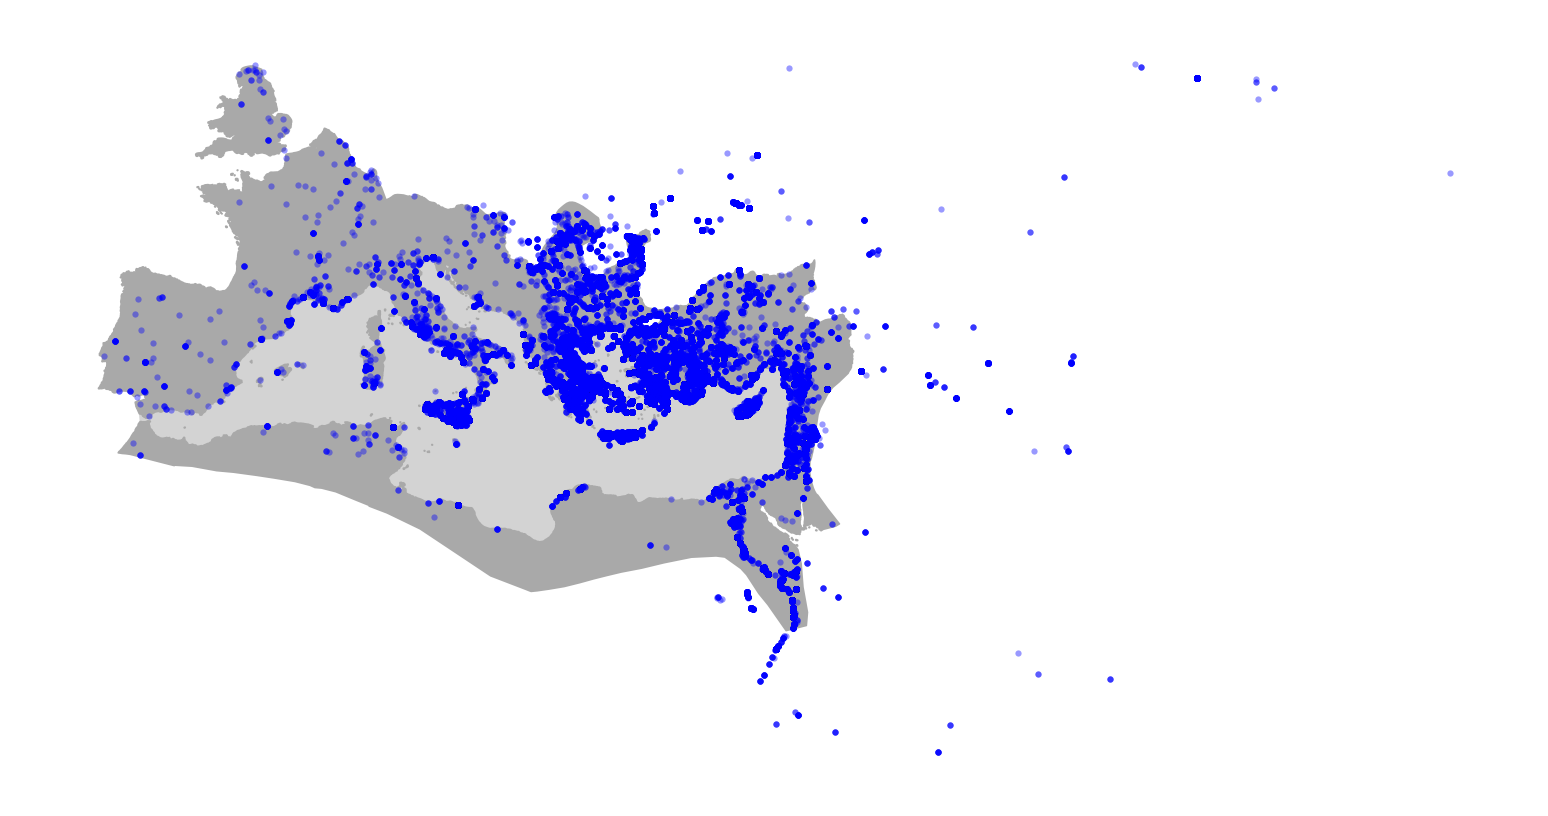

In [18]:
fig, ax = plt.subplots()
gpd.GeoSeries(medsea_merged_buffer).plot(ax=ax, color="lightgrey")
gpd.GeoSeries(pleiades_regions_merged_buffer).plot(ax=ax, color="darkgrey")
GIST.plot(ax=ax, marker=".", markersize=1, color="blue", zorder=3, alpha=0.4)
ax.set_axis_off()

In [20]:
GIRE = GIST[GIST["x_long"].notnull()]

In [42]:
len(GIRE)

180061

In [44]:
len(GIRE[GIRE.within(pleiades_regions_merged)])

143750

In [135]:
len(GIRE[GIRE.within(pleiades_regions_merged_buffer)])

169812

In [45]:
empireANDsea = unary_union([medsea_merged_buffer, pleiades_regions_merged_buffer])

In [46]:
within_empireANDsea_mask = GIRE.within(empireANDsea)

In [47]:
within_empireANDsea_mask.sum()

173643

In [48]:
180061 - 173643

6418

In [49]:
GIRE = GIRE[within_empireANDsea_mask]
len(GIRE)

173643

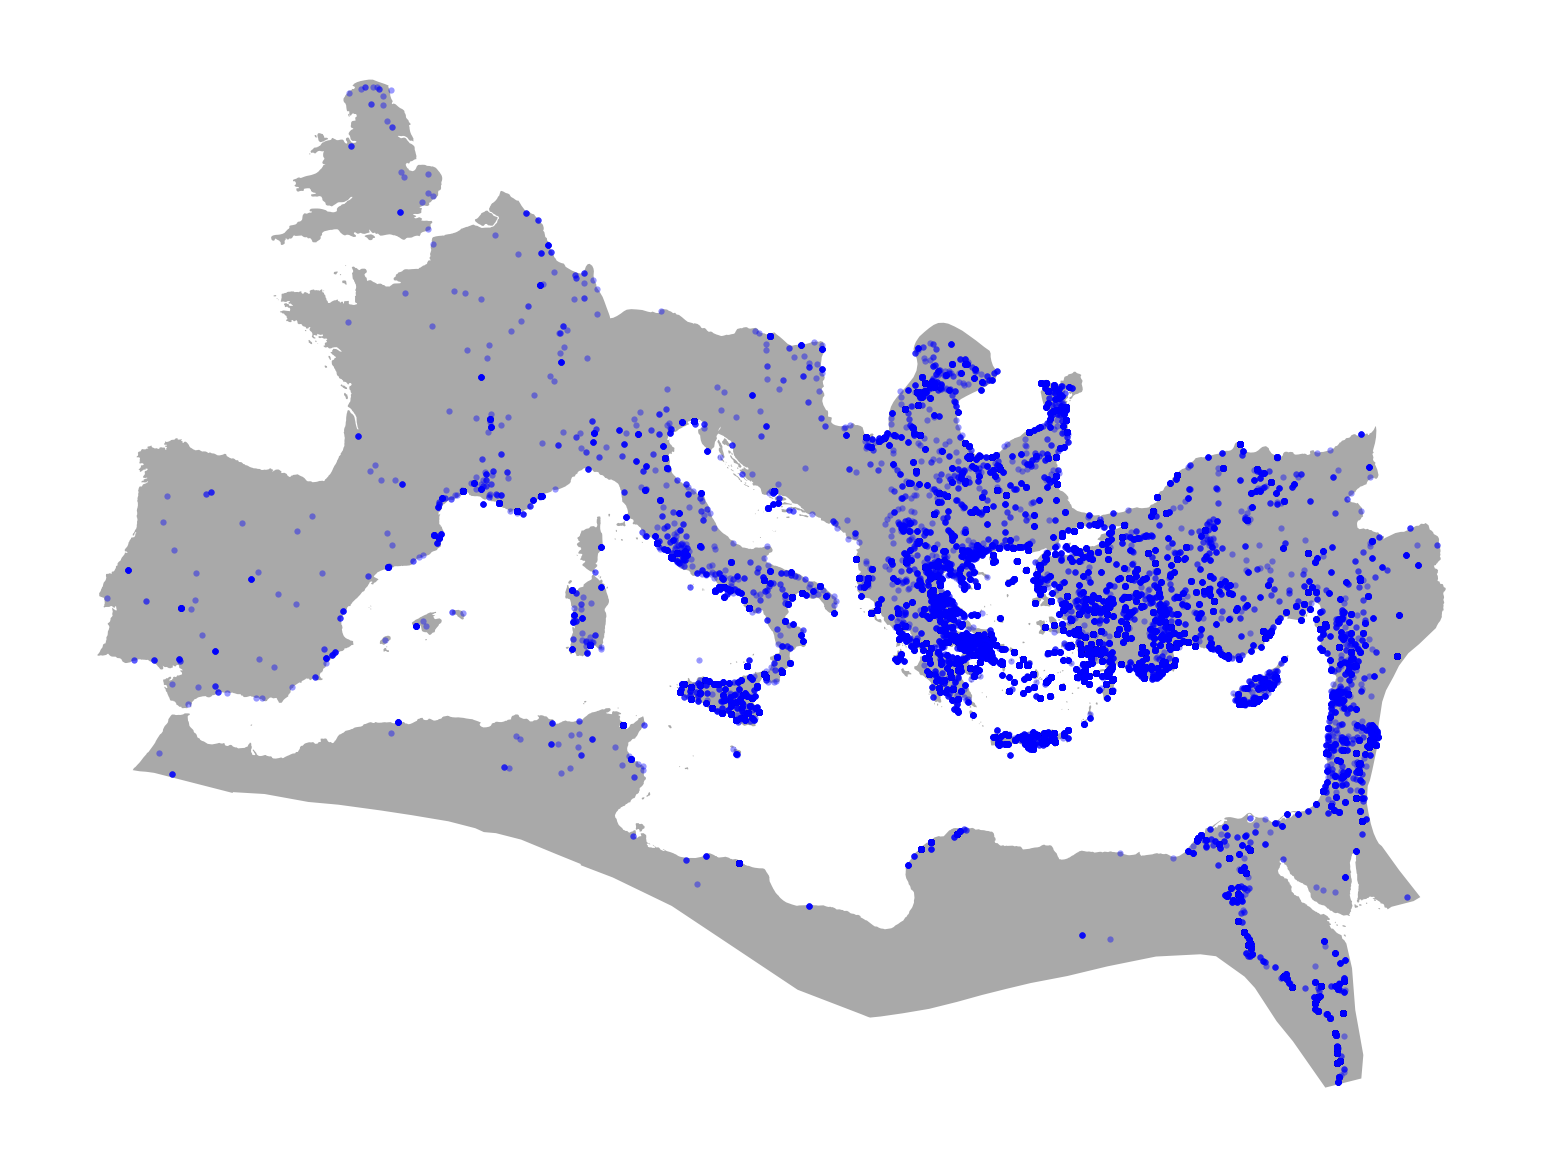

In [50]:
fig, ax = plt.subplots()
gpd.GeoSeries(pleiades_regions_merged).plot(ax=ax, color="darkgrey")
GIRE.plot(ax=ax, marker=".", markersize=1, color="blue", zorder=3, alpha=0.4)
ax.set_axis_off()

In [52]:
print("hello")

hello


In [55]:
withdate_mask = (GIRE["not_after"].notnull()) | (GIRE["not_before"].notnull())
withdate_mask.sum()

101667

In [56]:
romanperiod_mask = (GIRE["not_before"].between(-50, 350) | (GIRE["not_after"].between(-50, 350)))
romanperiod_mask.sum()

52542

In [57]:
GIRE = GIRE[romanperiod_mask]

52542

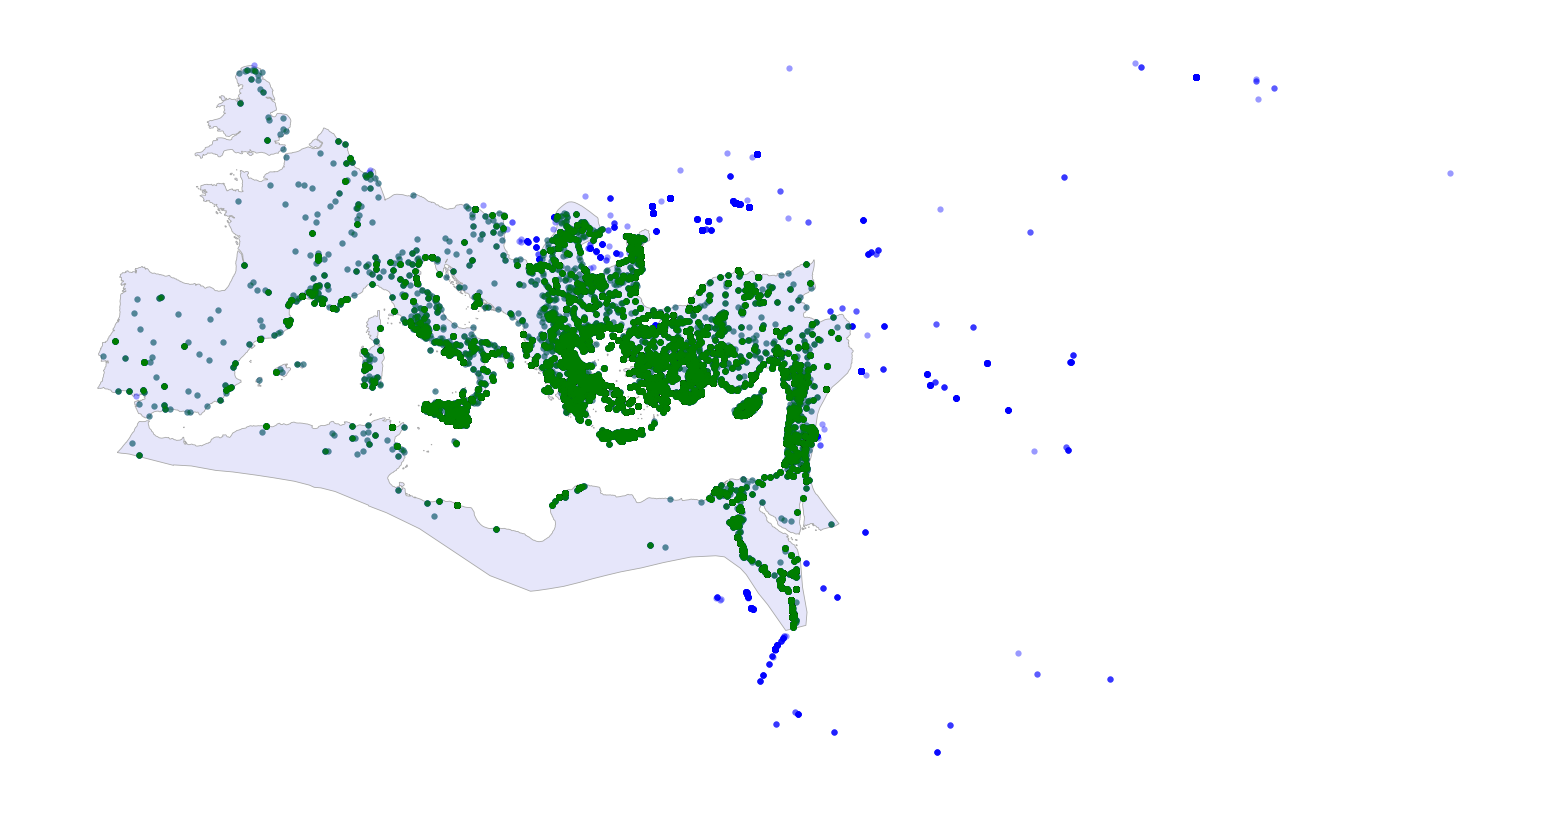

In [64]:
fig, ax = plt.subplots()
gpd.GeoSeries(pleiades_regions_merged).plot(ax=ax, edgecolor="darkgrey" , linewidth=0.2, color="lavender")
#gplt.kdeplot(PHI[PHI["x_long"].notnull()], cmap=plt.get_cmap("Greens"), ax=ax, alpha=0.5, shade=True, zorder=2)
GIST.plot(ax=ax, marker=".", markersize=1, color="blue", zorder=3, alpha=0.4)
GIRE.plot(ax=ax, marker=".", markersize=1, color="green", zorder=3, alpha=0.4)
ax.set_axis_off()

In [65]:
GIRE["GIRE_ID"] = range(1, len(GIRE)+1)

In [66]:
GIRE.set_index("GIRE_ID", inplace=True)

In [70]:
GIRE.to_file("../data/large_data/GIRE_v0.2.geojson", driver="GeoJSON")

In [71]:
GIRE.to_parquet("../data/large_data/GIRE_v0.2.parquet")